In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import prepare
import explore
import model
from wordcloud import WordCloud
from matplotlib import style
style.use("ggplot")
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

In [2]:
#make df from data.json
df = pd.read_json('data.json')
df.head()

,repo,language,readme_contents
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...
2,sychi77/Thoracic_Surgery_Patient_Survival,Jupyter Notebook,# Thoracic Surgery for Lung Cancer Data Set\n ...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Jupyter Notebook,# HackerRank Data Scientist Hiring Test: Predi...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github..."


In [3]:
# how many rows  have readme_contents with length == 0
df[df['readme_contents'].str.len() == 0].language.value_counts()


Jupyter Notebook    10
R                    5
Stata                3
HTML                 2
Python               1
Objective-C          1
Scheme               1
Name: language, dtype: int64

In [4]:
df["no_readme_contents"] = df["readme_contents"].str.len()==0
# person of language with no readme_contents
df.groupby("language")["no_readme_contents"].mean().sort_values(ascending=False)

language
Objective-C         1.000000
Scheme              1.000000
Stata               0.600000
Jupyter Notebook    0.208333
R                   0.161290
HTML                0.090909
Python              0.052632
Dart                0.000000
Java                0.000000
JavaScript          0.000000
MATLAB              0.000000
Ruby                0.000000
Scala               0.000000
Shell               0.000000
Swift               0.000000
TypeScript          0.000000
Name: no_readme_contents, dtype: float64

In [5]:
# how many languages are there?
df['language'].value_counts()

Jupyter Notebook    48
R                   31
HTML                22
Python              19
JavaScript          16
Stata                5
Java                 3
Dart                 3
Scala                2
Swift                2
MATLAB               1
Shell                1
TypeScript           1
Ruby                 1
Objective-C          1
Scheme               1
Name: language, dtype: int64

In [6]:
df= prepare.prep_data(df)

In [7]:
df["no_readme_contents"] = df["more_clean"].str.len()==0

# person of language with no readme_contents
df.groupby("language")["no_readme_contents"].mean().sort_values(ascending=False)

language
HTML      0.0
Other     0.0
Python    0.0
R         0.0
Name: no_readme_contents, dtype: float64

In [8]:
# how many rows do we have
df.shape[0]

134

In [9]:
# how many rows are missing readme data
df[df.no_readme_contents==True].shape[0]

0

In [10]:
df[df.no_readme_contents==True].language.value_counts()

Series([], Name: language, dtype: int64)

In [11]:
df.head()

,repo,language,original,no_readme_contents,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,False,reduction life expectancy brazil covid provide...,abstract school brazil method mtmato davis ass...,2949,352,211,life,expectancy,covid,state,data
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,False,animated annual change lifeexpectancy illustra...,change lifeexpectancy annual result life anima...,166,16,16,animated,annual,change,lifeexpectancy,illustration
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,False,thoracic surgery lung cancer data set uci mach...,abstract arff one associated cancer powerpoint...,2058,234,150,surgery,f,data,lung,thoracic
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,False,hackerrank data scientist hiring test predict ...,repo provision try saved csv united data every...,1011,135,86,country,life,expectancy,must,test
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",False,p aligncenter img srchttpsgithubcomoxforddemsc...,excess working repo programming funding large ...,2259,234,172,data,relates,code,p,generic


In [12]:
# how many languages are there?
df['language'].value_counts()

Python    56
Other     32
R         26
HTML      20
Name: language, dtype: int64

In [13]:
# make vectorizer
tfidf = TfidfVectorizer()
# fit the vectorizer to the data and make df
X = tfidf.fit_transform(df['more_clean'])
y = df['language']

# split data into train and test
X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)

In [14]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))


In [15]:
def baseline_accuracy(df, mode):
    """
    Calculate baseline accuracy
    """
    df['mode'] = mode
    baseline_accuracy = accuracy_score(df['actual'], df['mode'])
    return baseline_accuracy

In [16]:
def baseline_accuracy2(series, mode):
    """
    Calculate baseline accuracy
    """
    test=pd.DataFrame(series)
    test['mode'] = mode
    baseline_accuracy = accuracy_score(test['language'], test['mode'])
    return baseline_accuracy

In [17]:
#get mode to use as baseline
mode = df.language.mode().values[0]
#get baseline_accuracy
train_baseline = baseline_accuracy(train, mode)
validate_baseline = baseline_accuracy(validate, mode)
test_baseline = baseline_accuracy(test, mode)



In [18]:
# make a df for results
results = pd.DataFrame()
baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
results = pd.concat([results, baseline_model],axis = 0)
results.T

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline
0,baseline,baseline,NaN,0.418919,0.424242,0.407407,False


In [19]:
results.shape[1]

1

In [20]:
# make a df for results
results = pd.DataFrame()
baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
results = pd.concat([results, baseline_model],axis = 0)
results.T
# make more models varying solver
model_number = results.shape[1]
for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
    lm = LogisticRegression(solver=solver).fit(X_train, y_train)
    # run model on data splits
    train['predicted'] = lm.predict(X_train)
    validate['predicted'] = lm.predict(X_validate)
    test['predicted'] = lm.predict(X_test)
    # make results series to add to results df
    stats = pd.Series(
        {'model_number':model_number,
            'model_type':'LogisticRegression',
            'solver':solver,
            'train_accuracy':accuracy_score(y_train, train['predicted']),
            'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
            'test_accuracy':accuracy_score(y_test, test['predicted']),
            'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
            'include_jupyter_notebook':'Jupyter Notebook' in df.language
        })
    # add to results df
    results = pd.concat([results, stats], axis = 1)
    model_number += 1

results.T.reset_index(drop=True)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,include_jupyter_notebook
0,baseline,baseline,NaN,0.418919,0.424242,0.407407,False,NaN
1,1,LogisticRegression,liblinear,0.783784,0.424242,0.444444,False,False
2,2,LogisticRegression,lbfgs,0.851351,0.424242,0.444444,False,False
3,3,LogisticRegression,newton-cg,0.851351,0.424242,0.444444,False,False
4,4,LogisticRegression,sag,0.851351,0.424242,0.444444,False,False
5,5,LogisticRegression,saga,0.918919,0.454545,0.481481,True,False


In [21]:
def drop_low_count_languages(df, threshold=3):
    """
    Drop languages with less than threshold number of entries
    """
    languages = (df['language'].value_counts()>3)
    to_keep = languages[languages==True].index.tolist()
    df = df[df['language'].isin(to_keep)]
    return df

In [22]:
tfidf = TfidfVectorizer()
# fit the vectorizer to the data and make df
X = tfidf.fit_transform(df['more_clean'])
X

<134x4418 sparse matrix of type '<class 'numpy.float64'>'
	with 10335 stored elements in Compressed Sparse Row format>

In [23]:
def run_models(drop_jupyter=True, drop_low_count_langs=True, n_languages=3):
    """
    Run models on data varying solver
    """
    #get raw data
    df = pd.read_json('data.json')
    # clean data
    df['more_clean'] = df['readme_contents'].apply(prepare.more_clean)
    if drop_jupyter:
        df = df[df['language'] != 'Jupyter Notebook']
    if drop_low_count_langs:
        df = drop_low_count_languages(df)
    df = prepare.keep_top_n_languages(df, n_languages=n_languages)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
        lm = LogisticRegression(solver=solver).fit(X_train, y_train)
        # run model on data splits
        train['predicted'] = lm.predict(X_train)
        validate['predicted'] = lm.predict(X_validate)
        test['predicted'] = lm.predict(X_test)
        # make results series to add to results df
        stats = pd.Series(
        {'model_number':model_number,
            'model_type':'LogisticRegression',
            'solver':solver,
            'train_accuracy':accuracy_score(y_train, train['predicted']),
            'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
            'test_accuracy':accuracy_score(y_test, test['predicted']),
            'baseline_accuracy':validate_baseline,
            'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
            'drop_jupyter':drop_jupyter,
            'drop_low_count_languages':drop_low_count_langs,
            'n_languages':n_languages
        })
        # add to results df
        results = pd.concat([results, stats], axis = 1)
        model_number += 1

    return results.T.reset_index(drop=True)


In [24]:
run_models(drop_jupyter=True, drop_low_count_langs=True, n_languages=3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,baseline_accuracy,drop_jupyter,drop_low_count_languages,n_languages
0,baseline,baseline,NaN,0.333333,0.347826,0.315789,False,NaN,NaN,NaN,NaN
1,1,LogisticRegression,liblinear,0.882353,0.347826,0.368421,False,0.347826,True,True,3
2,2,LogisticRegression,lbfgs,0.901961,0.347826,0.368421,False,0.347826,True,True,3
3,3,LogisticRegression,newton-cg,0.901961,0.347826,0.368421,False,0.347826,True,True,3
4,4,LogisticRegression,sag,0.901961,0.347826,0.368421,False,0.347826,True,True,3
5,5,LogisticRegression,saga,0.901961,0.347826,0.421053,False,0.347826,True,True,3


In [25]:
run_models(drop_jupyter=False, drop_low_count_langs=True, n_languages=3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,baseline_accuracy,drop_jupyter,drop_low_count_languages,n_languages
0,baseline,baseline,NaN,0.346154,0.323529,0.344828,False,NaN,NaN,NaN,NaN
1,1,LogisticRegression,liblinear,0.871795,0.382353,0.344828,True,0.323529,False,True,3
2,2,LogisticRegression,lbfgs,0.923077,0.382353,0.37931,True,0.323529,False,True,3
3,3,LogisticRegression,newton-cg,0.923077,0.382353,0.37931,True,0.323529,False,True,3
4,4,LogisticRegression,sag,0.923077,0.382353,0.37931,True,0.323529,False,True,3
5,5,LogisticRegression,saga,0.923077,0.382353,0.37931,True,0.323529,False,True,3


In [26]:
run_models(drop_jupyter=False, drop_low_count_langs=False, n_languages=3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,baseline_accuracy,drop_jupyter,drop_low_count_languages,n_languages
0,baseline,baseline,NaN,0.391304,0.4,0.382353,False,NaN,NaN,NaN,NaN
1,1,LogisticRegression,liblinear,0.695652,0.5,0.411765,True,0.4,False,False,3
2,2,LogisticRegression,lbfgs,0.782609,0.525,0.441176,True,0.4,False,False,3
3,3,LogisticRegression,newton-cg,0.782609,0.525,0.441176,True,0.4,False,False,3
4,4,LogisticRegression,sag,0.782609,0.525,0.441176,True,0.4,False,False,3
5,5,LogisticRegression,saga,0.793478,0.525,0.441176,True,0.4,False,False,3


In [27]:
def run_models2(drop_jupyter=True, drop_low_count_langs=True, drop_empty_readmes=True, n_languages=3):
    """
    Run models on data varying solver and C value
    """
    #get raw data
    df = pd.read_json('data.json')
    # clean data
    df['more_clean'] = df['readme_contents'].apply(prepare.more_clean)
    if drop_jupyter:
        df = df[df['language'] != 'Jupyter Notebook']
    if drop_low_count_langs:
        df = drop_low_count_languages(df)
    if drop_empty_readmes:
        df = df[df['more_clean'] != '']
    df = prepare.keep_top_n_languages(df, n_languages=n_languages)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','solver':np.nan,'train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
        for c in c_values:
            #make the model
            lm = LogisticRegression(C=c, solver=solver).fit(X_train, y_train)
            # run model on data splits
            train['predicted'] = lm.predict(X_train)
            validate['predicted'] = lm.predict(X_validate)
            test['predicted'] = lm.predict(X_test)
            # make results series to add to results df
            stats = pd.Series(
            {'model_number':model_number,
                'model_type':'LogisticRegression',
                'solver':solver,
                'C':c,
                'train_accuracy':accuracy_score(y_train, train['predicted']),
                'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
                'test_accuracy':accuracy_score(y_test, test['predicted']),
                'baseline_accuracy':validate_baseline,
                'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
                'drop_jupyter':drop_jupyter,
                'drop_low_count_languages':drop_low_count_langs,
                'drop_empty_readmes':drop_empty_readmes,
                'n_languages':n_languages
            })
            # add to results df
            results = pd.concat([results, stats], axis = 1)
            model_number += 1

    return results.T.reset_index(drop=True)

In [28]:
run_models2(drop_jupyter=True, drop_low_count_langs=True, n_languages=3).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,baseline_accuracy,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
28,28,LogisticRegression,sag,1.0,0.7,0.411765,True,1000,0.35,True,True,True,3
7,7,LogisticRegression,liblinear,1.0,0.7,0.470588,True,1000,0.35,True,True,True,3
21,21,LogisticRegression,newton-cg,1.0,0.7,0.411765,True,1000,0.35,True,True,True,3


In [29]:
run_models2(drop_jupyter=False, drop_low_count_langs=True, n_languages=3).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,baseline_accuracy,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
33,33,LogisticRegression,saga,1.0,0.551724,0.583333,True,10,0.310345,False,True,True,3
5,5,LogisticRegression,liblinear,1.0,0.551724,0.583333,True,10,0.310345,False,True,True,3
26,26,LogisticRegression,sag,1.0,0.551724,0.625,True,10,0.310345,False,True,True,3


In [30]:
run_models2(drop_jupyter=False, drop_low_count_langs=False, n_languages=3).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,baseline_accuracy,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
0,baseline,baseline,NaN,0.397436,0.411765,0.392857,False,NaN,NaN,NaN,NaN,NaN,NaN
15,15,LogisticRegression,newton-cg,0.397436,0.411765,0.392857,False,0.001,0.411765,False,False,True,3
32,32,LogisticRegression,saga,0.910256,0.411765,0.571429,False,1,0.411765,False,False,True,3


In [31]:
run_models2(drop_jupyter=False, drop_low_count_langs=False, drop_empty_readmes=True, n_languages=3).sort_values(['validate_accuracy','test_accuracy'], ascending=False).head(3)

,model_number,model_type,solver,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,C,baseline_accuracy,drop_jupyter,drop_low_count_languages,drop_empty_readmes,n_languages
5,5,LogisticRegression,liblinear,1.0,0.411765,0.571429,False,10,0.411765,False,False,True,3
11,11,LogisticRegression,lbfgs,0.897436,0.411765,0.571429,False,1,0.411765,False,False,True,3
12,12,LogisticRegression,lbfgs,1.0,0.411765,0.571429,False,10,0.411765,False,False,True,3


In [32]:
# moved to prepare.py
# 
# # which word is the most common in the string
# def n_most_common_word(string, n=1):
#     """
#     Return the most common word in a string
#     """
#     words = string.split()
#     if len(words) < n:
#         return ''
#     word_counts = Counter(words)
#     return word_counts.most_common(n)[n-1][0]

# n_most_common_word(df.more_clean[1],3)

In [33]:
def run_models5():
    """
    Run models on data varying solver and C value
    """
    #get raw data
    df = pd.read_json('data.json')
    # clean data
    df = prepare.prep_data(df)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
        for c in c_values:
            #make the model
            lm = LogisticRegression(C=c, solver=solver).fit(X_train, y_train)
            # run model on data splits
            train['predicted'] = lm.predict(X_train)
            validate['predicted'] = lm.predict(X_validate)
            test['predicted'] = lm.predict(X_test)
            # make results series to add to results df
            stats = pd.Series(
            {'model_number':model_number,
                'model_type':'LogisticRegression',
                'solver':solver,
                'C':c,
                'train_accuracy':accuracy_score(y_train, train['predicted']),
                'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
                'test_accuracy':accuracy_score(y_test, test['predicted']),
                'baseline_accuracy':validate_baseline,
                'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
            })
            # add to results df
            results = pd.concat([results, stats], axis = 1)
            model_number += 1

    return results.T.reset_index(drop=True)

In [34]:
run_models5().sort_values(['validate_accuracy', 'test_accuracy'], ascending=False).head(10)

,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,solver,C,baseline_accuracy
14,14,LogisticRegression,0.986486,0.606061,0.555556,True,lbfgs,1000,0.424242
21,21,LogisticRegression,0.986486,0.606061,0.555556,True,newton-cg,1000,0.424242
6,6,LogisticRegression,0.986486,0.606061,0.518519,True,liblinear,100,0.424242
7,7,LogisticRegression,0.986486,0.575758,0.555556,True,liblinear,1000,0.424242
13,13,LogisticRegression,0.986486,0.575758,0.555556,True,lbfgs,100,0.424242
20,20,LogisticRegression,0.986486,0.575758,0.555556,True,newton-cg,100,0.424242
27,27,LogisticRegression,0.986486,0.545455,0.592593,True,sag,100,0.424242
28,28,LogisticRegression,0.986486,0.545455,0.555556,True,sag,1000,0.424242
5,5,LogisticRegression,0.986486,0.545455,0.518519,True,liblinear,10,0.424242
12,12,LogisticRegression,0.986486,0.545455,0.518519,True,lbfgs,10,0.424242


In [35]:
def run_models3():
    """
    Run models with decision tree classifier
    """
    #get raw data
    df = pd.read_json('data.json')
    df = prepare.prep_data(df)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    max_depths = [1, 2, 3, 4, 5, 10, 100]
    for max_depth in max_depths:
        #make the model
        dtc = DecisionTreeClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)
        # run model on data splits
        train['predicted'] = dtc.predict(X_train)
        validate['predicted'] = dtc.predict(X_validate)
        test['predicted'] = dtc.predict(X_test)
        # make results series to add to results df
        stats = pd.Series(
        {'model_number':model_number,
            'model_type':'DecisionTreeClassifier',
            'max_depth':max_depth,
            'train_accuracy':accuracy_score(y_train, train['predicted']),
            'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
            'test_accuracy':accuracy_score(y_test, test['predicted']),
            'baseline_accuracy':validate_baseline,
            'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
        })
        # add to results df
        results = pd.concat([results, stats], axis = 1)
        model_number += 1

    return results.T.reset_index(drop=True)

In [36]:
run_models3().sort_values(['validate_accuracy', 'test_accuracy'], ascending=False).head(10)

,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,max_depth,baseline_accuracy
2,2,DecisionTreeClassifier,0.513514,0.454545,0.333333,True,2,0.424242
5,5,DecisionTreeClassifier,0.72973,0.454545,0.333333,True,5,0.424242
0,baseline,baseline,0.418919,0.424242,0.407407,False,NaN,NaN
1,1,DecisionTreeClassifier,0.418919,0.424242,0.407407,False,1,0.424242
6,6,DecisionTreeClassifier,0.959459,0.424242,0.37037,False,10,0.424242
7,7,DecisionTreeClassifier,0.986486,0.424242,0.37037,False,100,0.424242
4,4,DecisionTreeClassifier,0.662162,0.424242,0.333333,False,4,0.424242
3,3,DecisionTreeClassifier,0.581081,0.393939,0.333333,False,3,0.424242


In [37]:
def run_models4():
    """
    Run models with decision tree classifier
    """
    #get raw data
    df = pd.read_json('data.json')
    df = prepare.prep_data(df)
    # make vectorizer
    tfidf = TfidfVectorizer()
    # fit the vectorizer to the data and make df
    X = tfidf.fit_transform(df['more_clean'])
    y = df['language']

    # split data into train and test
    X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.split_data_xy(X, y)
    train = pd.DataFrame(dict(actual=y_train))
    validate = pd.DataFrame(dict(actual=y_validate))
    test = pd.DataFrame(dict(actual=y_test))
    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy(train, mode)
    validate_baseline = baseline_accuracy(validate, mode)
    test_baseline = baseline_accuracy(test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    max_depths = [1, 2, 3, 4, 5, 10, 100]
    min_sample_leafs = [1, 2, 3, 4, 5, 10, 100]
    criterion = ['gini', 'entropy']
    for max_depth in max_depths:
        for min_samples_leaf in min_sample_leafs:
            for crit in criterion: 
                #make the model
                rf = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42, criterion=crit).fit(X_train, y_train)
                # run model on data splits
                train['predicted'] = rf.predict(X_train)
                validate['predicted'] = rf.predict(X_validate)
                test['predicted'] = rf.predict(X_test)
                # make results series to add to results df
                stats = pd.Series(
                {'model_number':model_number,
                    'model_type':'RandomForest',
                    'max_depth':max_depth,
                    'min_samples_leaf':min_samples_leaf,
                    'criterion':crit,
                    'train_accuracy':accuracy_score(y_train, train['predicted']),
                    'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
                    'test_accuracy':accuracy_score(y_test, test['predicted']),
                    'baseline_accuracy':validate_baseline,
                    'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
                })
                # add to results df
                results = pd.concat([results, stats], axis = 1)
                model_number += 1

    return results.T.reset_index(drop=True)

In [38]:
results = run_models4()#.sort_values(['validate_accuracy','test_accuracy'], ascending=False).head(3)

In [39]:
results.sort_values(['validate_accuracy','test_accuracy'], ascending=False).head(3)

,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,max_depth,min_samples_leaf,criterion,baseline_accuracy
85,85,RandomForest,0.986486,0.484848,0.481481,True,100,1,gini,0.424242
73,73,RandomForest,0.810811,0.484848,0.444444,True,10,2,gini,0.424242
74,74,RandomForest,0.783784,0.484848,0.444444,True,10,2,entropy,0.424242


In [40]:
df = pd.read_json('data.json')
df = prepare.prep_data(df)
train = prepare.split_data(df)[0]
train.head()

,repo,language,original,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
151,ashleyvarma/TooltipViz,Other,# TooltipViz\nScatter plot of fertility (x axi...,tooltipviz scatter plot fertility x axis v lif...,line live scatter fertility tooltip life popul...,196,25,23,axis,see,tooltipviz,scatter,plot
12,BatuhanSeremet/Life_Expectancy-Regression,Python,# Life_Expectancy-Regression\n\nThis project i...,lifeexpectancyregression project includes lith...,life country includes lifeexpectancyregression...,219,25,21,project,life,expectancy,model,lifeexpectancyregression
76,neilnatarajan/toilet_used,Python,# toilet_used\nlife expectancy prediction\n,toiletused life expectancy prediction,expectancy toiletused prediction life,37,4,4,toiletused,life,expectancy,prediction,
19,aris-plexi/GDP_LE,HTML,# GDP_LE\nIn this project I use matplotlib and...,gdple project use matplotlib seaborn python mo...,matplotlib module python seaborn gdple economi...,118,15,15,gdple,project,use,matplotlib,seaborn
6,libre-money-projects/Geconomicus,Python,# Ğeconomicus\nĞeconomicus is a generic free e...,geconomicus geconomicus generic free economic ...,following dividend payetm sphinx chatroom icc ...,2754,345,189,geconomicus,install,venv,money,bash


In [41]:
def get_common_unique_words(text, threshold=5):
    """
    Get common unique words in dataframe, aka words that occur in multiple readme's
    a word must appear in at least threshold readmes to be considered a common word
    """

    words = text.split()
    counter = Counter(words)
    common_unique_words = [word for word, count in counter.items() if count >= threshold]
    new_string = ' '.join(common_unique_words)
    return new_string

In [42]:
# combine all strings in more_clean where language is the same
languages = train.groupby('language')['more_clean'].apply(lambda x: ' '.join(x)).reset_index()
languages.rename(columns={'more_clean':'all_words'}, inplace=True)
languages['unique_words'] = train.groupby('language')['unique_words'].apply(lambda x: ' '.join(x)).values
languages['common_unique_words'] = languages.unique_words.apply(get_common_unique_words)
languages['n_words'] = languages['all_words'].apply(lambda x: len(x.split()))
languages['unique_word_count'] = languages['all_words'].apply(lambda x: len(set(x.split())))
languages['mean_word_count'] = train.groupby('language')['word_count'].mean().values.round(1)
languages['median_word_count'] = train.groupby('language')['word_count'].median().values.round(1)
languages['most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x))
languages['2nd_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,2))
languages['3rd_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,3))
languages['4th_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,4))
languages['5th_most_common_word'] = languages['unique_words'].apply(lambda x: prepare.n_most_common_word(x,5))
languages


,language,all_words,unique_words,common_unique_words,n_words,unique_word_count,mean_word_count,median_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,HTML,gdple project use matplotlib seaborn python mo...,matplotlib module python seaborn gdple economi...,life country project expectancy data,755,421,68.6,26.0,life,expectancy,project,country,data
1,Other,tooltipviz scatter plot fertility x axis v lif...,line live scatter fertility tooltip life popul...,life expectancy see data project code file usi...,2179,948,128.2,47.0,life,expectancy,project,code,using
2,Python,lifeexpectancyregression project includes lith...,life country includes lifeexpectancyregression...,life country regression feature expectancy pro...,5434,1690,175.3,78.0,life,expectancy,project,data,country
3,R,lifeexpectancyvsgdp recently discovered gganim...,animation altanimated stylewidth lifeexpectanc...,life year data r expectancy using run model on...,3007,1140,200.5,78.0,life,expectancy,data,country,year


In [43]:
# makes sets of all words in all languages so no words are repeated
html_set = set(languages[languages.language=='HTML'].common_unique_words.values[0].split())
python_set = set(languages[languages.language=='Python'].common_unique_words.values[0].split())
r_set = set(languages[languages.language=='R'].common_unique_words.values[0].split())
other_set = set(languages[languages.language=='Other'].common_unique_words.values[0].split())
#remove words found in other languages
unique_to_html = " ".join(html_set - python_set - r_set - other_set)
unique_to_python = " ".join(python_set - html_set - r_set - other_set)
unique_to_r = " ".join(r_set - html_set - python_set - other_set)
unique_to_other = " ".join(other_set - html_set - python_set - r_set)
# make a series to add to the dataframe
unique_to_lang = [unique_to_html, unique_to_other, unique_to_python, unique_to_r]


# unique to lang is performed on full df but will be done on train then used for model


In [44]:
languages['unique_to_language'] = unique_to_lang
languages.head()

,language,all_words,unique_words,common_unique_words,n_words,unique_word_count,mean_word_count,median_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word,unique_to_language
0,HTML,gdple project use matplotlib seaborn python mo...,matplotlib module python seaborn gdple economi...,life country project expectancy data,755,421,68.6,26.0,life,expectancy,project,country,data,
1,Other,tooltipviz scatter plot fertility x axis v lif...,line live scatter fertility tooltip life popul...,life expectancy see data project code file usi...,2179,948,128.2,47.0,life,expectancy,project,code,using,application take
2,Python,lifeexpectancyregression project includes lith...,life country includes lifeexpectancyregression...,life country regression feature expectancy pro...,5434,1690,175.3,78.0,life,expectancy,project,data,country,various live dataset linear health insight cas...
3,R,lifeexpectancyvsgdp recently discovered gganim...,animation altanimated stylewidth lifeexpectanc...,life year data r expectancy using run model on...,3007,1140,200.5,78.0,life,expectancy,data,country,year,r repository v


In [45]:
languages[['language','unique_to_language']]

,language,unique_to_language
0,HTML,
1,Other,application take
2,Python,various live dataset linear health insight cas...
3,R,r repository v


In [46]:
len(languages[languages.language == 'Python']['unique_to_language'].values[0].split())


67

In [47]:
languages[languages.language == 'Python']['unique_to_language'].values[0]

'various live dataset linear health insight case birth python provided every correlation bmi gdp time system lifeexpectancy made regression based created also many better alcohol machine sex resource information related value u people organization show number disease find used set global specific per accuracy well variable rate column average first available death prediction learning factor feature world human fit source given effect expenditure predict economic predicting use'

In [48]:
languages[languages.language == 'Other']['unique_to_language'].values[0]

'application take'

In [49]:
languages[languages.language == 'R']['unique_to_language'].values[0]

'r repository v'

In [50]:
languages[languages.language == 'HTML']['unique_to_language'].values[0]


''

(-0.5, 399.5, 199.5, -0.5)

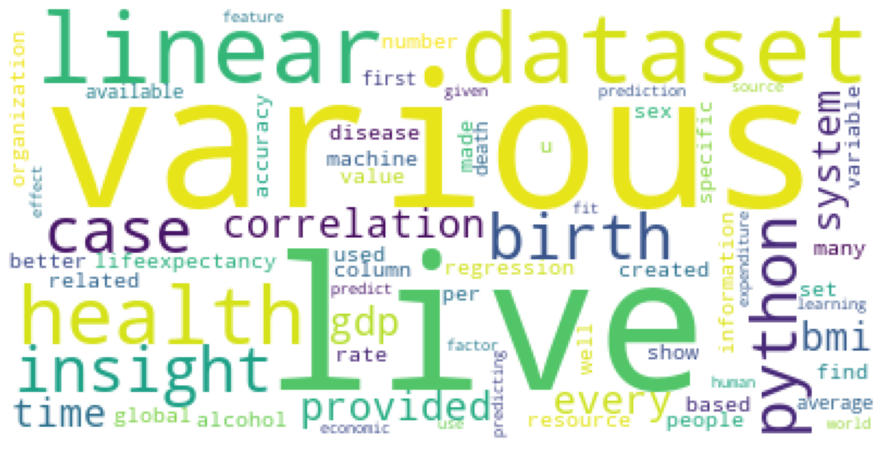

In [51]:
img = WordCloud(background_color='white').generate(languages[languages.language == 'Python']['unique_to_language'].values[0])
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

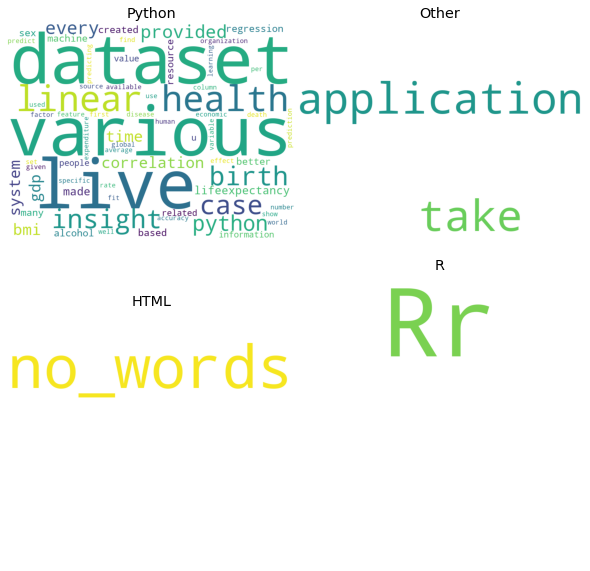

In [52]:
r_cloud = WordCloud(background_color='white', height=1000, width=400).generate("Rr  ")
html_cloud = WordCloud(background_color='white', height=600, width=800).generate("no_words")
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(languages[languages.language == 'Python']['unique_to_language'].values[0])
other_cloud = WordCloud(background_color='white', height=600, width=800).generate(languages[languages.language == 'Other']['unique_to_language'].values[0])

plt.figure(figsize=(8, 8))
axs = [plt.axes([0, .5, .5, .5]), plt.axes([0, 0, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([.5, .5, .5, .5])]

axs[0].imshow(python_cloud)
axs[1].imshow(html_cloud)
axs[2].imshow(r_cloud)
axs[3].imshow(other_cloud)

axs[0].set_title('Python')
axs[1].set_title('HTML')
axs[2].set_title('R')
axs[3].set_title('Other')

for ax in axs: ax.axis('off')


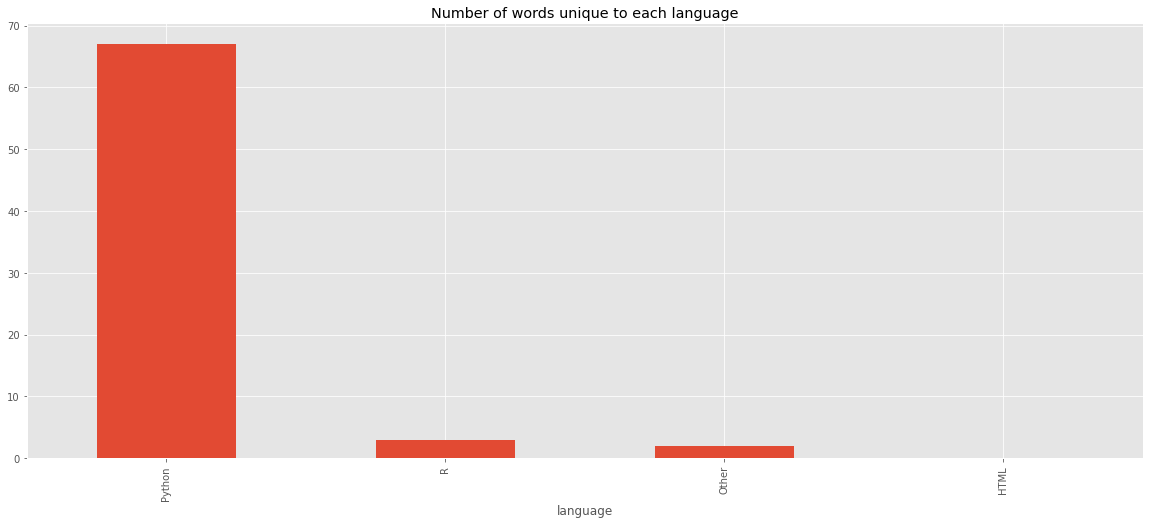

In [53]:
# graph number of words in unique_to_language
new_df= languages[['language','unique_to_language']]
#new_df.set_index('language', inplace=True)
new_df['unique_words'] = new_df['unique_to_language'].apply(lambda x: len(x.split()))
new_df.sort_values(by='unique_words', ascending=False, inplace=True)
new_df.plot.bar(x='language', y='unique_words')
plt.title('Number of words unique to each language')
plt.legend().set_visible(False)


In [54]:
other = (' '.join(train[train.language == 'Other'].more_clean)).split()
python = (' '.join(train[train.language == 'Python'].more_clean)).split()
r = (' '.join(train[train.language == 'R'].more_clean)).split()
html = (' '.join(train[train.language == 'HTML'].more_clean)).split()
all_words = (' '.join(train.more_clean)).split()

In [55]:
# make bigrams
top_5_other_bigrams = (pd.Series(nltk.ngrams(other, 2)).value_counts().head(5))
top_5_python_bigrams = (pd.Series(nltk.ngrams(python, 2)).value_counts().head(5))
top_5_r_bigrams = (pd.Series(nltk.ngrams(r, 2)).value_counts().head(5))
top_5_html_bigrams = (pd.Series(nltk.ngrams(html, 2)).value_counts().head(5))


Text(0.5, 1.0, 'R')

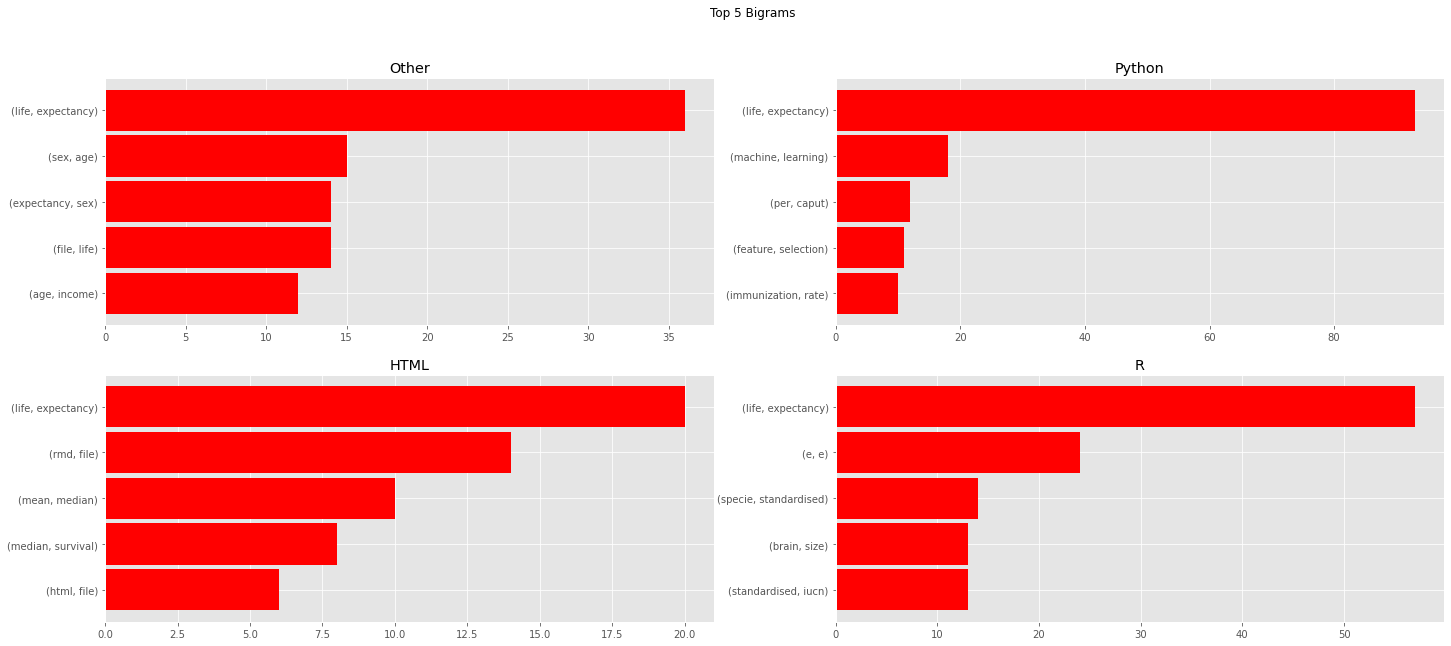

In [56]:
## Plot Top 5 Bigrams
fig, axs = plt.subplots(2, 2)
#set figure size
fig.set_size_inches(24, 10)
#set title
plt.suptitle('Top 5 Bigrams')
top_5_other_bigrams.sort_values().plot.barh(color='red', width=.9, ax=axs[0, 0])
axs[0,0].set_title('Other')
#axs[0,0].set_ylabel('Bigram')

top_5_python_bigrams.sort_values().plot.barh(color='red', width=.9, ax=axs[0, 1])
axs[0,1].set_title('Python')

top_5_html_bigrams.sort_values().plot.barh(color='red', width=.9, ax=axs[1, 0])
axs[1,0].set_title('HTML')

top_5_r_bigrams.sort_values().plot.barh(color='red', width=.9, ax=axs[1, 1])
axs[1,1].set_title('R')


In [57]:
def get_common_bigrams(text, threshold=5):
    '''
    This function takes in a text and returns a list of the top 5 bigrams that are common to the text.
    '''
    # get all bigrams in text
    bigrams = pd.Series(nltk.ngrams(text.split(), 2)).value_counts()
    # filter out bigrams that are less than threshold
    bigrams = bigrams[bigrams > threshold]
    # return all that occur more than 5 times
    return bigrams.index.values
    
languages['common_bigrams'] = languages.all_words.apply(lambda x: get_common_bigrams(x))

In [58]:
# add bigrams to language dataframe
languages['bigrams'] = languages.all_words.apply(lambda x: pd.Series(nltk.ngrams(x.split(), 2)).values)

# makes sets of all common bigrams in all languages so no bigrams are repeated
html_set = set(languages[languages.language=='HTML'].common_bigrams.values[0])
python_set = set(languages[languages.language=='Python'].common_bigrams.values[0])
r_set = set(languages[languages.language=='R'].common_bigrams.values[0])
other_set = set(languages[languages.language=='Other'].common_bigrams.values[0])
#remove words found in other languages
unique_to_html = (html_set - python_set - r_set - other_set)
unique_to_python = (python_set - html_set - r_set - other_set)
unique_to_r = (r_set - html_set - python_set - other_set)
unique_to_other = (other_set - html_set - python_set - r_set)
# make a series to add to the dataframe
unique_to_lang = [unique_to_html, unique_to_other, unique_to_python, unique_to_r]
languages['bigrams_unique_to_language'] = list(unique_to_lang)

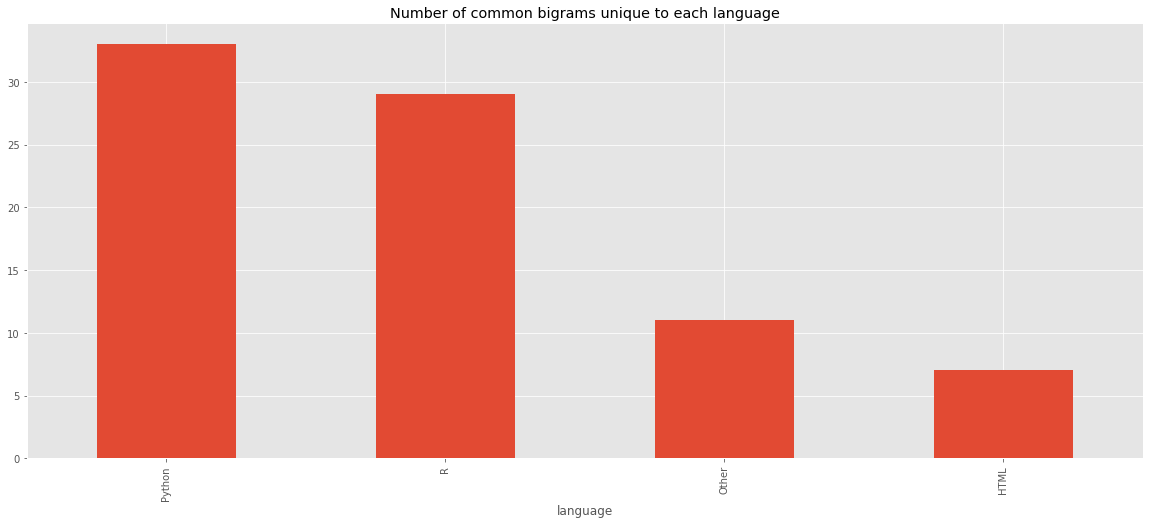

In [59]:
# graph number of bigrams in unique_to_language
new_df= languages[['language','bigrams_unique_to_language']]
#new_df.set_index('language', inplace=True)
new_df['unique_bigrams_count'] = new_df['bigrams_unique_to_language'].apply(lambda x: len(x))
new_df.sort_values(by='unique_bigrams_count', ascending=False, inplace=True)
new_df.plot.bar(x='language', y='unique_bigrams_count')
plt.title('Number of common bigrams unique to each language')
plt.legend().set_visible(False)

In [60]:
df.head(1)

,repo,language,original,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid provide...,abstract school brazil method mtmato davis ass...,2949,352,211,life,expectancy,covid,state,data


In [61]:
def bigram_count(bigrams, language):
    '''
    This function takes in a list of bigrams and returns the count of bigrams that are in the languages unique set.
    '''
    if language == 'HTML':
        unique_set = unique_to_html
    elif language == 'Python':
        unique_set = unique_to_python
    elif language == 'R':
        unique_set = unique_to_r
    elif language == 'Other':
        unique_set = unique_to_other

    count= 0
    for bigram in bigrams:
        if bigram in unique_set:
            count +=1
    return count

In [62]:
df['bigrams'] = df.more_clean.apply(lambda x: pd.Series(nltk.ngrams(x.split(), 2)).values)
df['python_bigrams'] = df.bigrams.apply(lambda x: bigram_count(x, 'Python'))
df['html_bigrams'] = df.bigrams.apply(lambda x: bigram_count(x, 'HTML'))
df['r_bigrams'] = df.bigrams.apply(lambda x: bigram_count(x, 'R'))
df['other_bigrams'] = df.bigrams.apply(lambda x: bigram_count(x, 'Other'))



In [63]:
df.head()

,repo,language,original,more_clean,unique_words,char_count,word_count,unique_word_count,most_common_word,2nd_most_common_word,3rd_most_common_word,4th_most_common_word,5th_most_common_word,bigrams,python_bigrams,html_bigrams,r_bigrams,other_bigrams
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid provide...,abstract school brazil method mtmato davis ass...,2949,352,211,life,expectancy,covid,state,data,"[(reduction, life), (life, expectancy), (expec...",2,0,1,0
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual change lifeexpectancy illustra...,change lifeexpectancy annual result life anima...,166,16,16,animated,annual,change,lifeexpectancy,illustration,"[(animated, annual), (annual, change), (change...",0,0,0,0
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,thoracic surgery lung cancer data set uci mach...,abstract arff one associated cancer powerpoint...,2058,234,150,surgery,f,data,lung,thoracic,"[(thoracic, surgery), (surgery, lung), (lung, ...",6,0,1,0
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,hackerrank data scientist hiring test predict ...,repo provision try saved csv united data every...,1011,135,86,country,life,expectancy,must,test,"[(hackerrank, data), (data, scientist), (scien...",4,0,0,0
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p aligncenter img srchttpsgithubcomoxforddemsc...,excess working repo programming funding large ...,2259,234,172,data,relates,code,p,generic,"[(p, aligncenter), (aligncenter, img), (img, s...",0,0,1,0


# resplit data with new features and try modeling again

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 165
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   repo                  134 non-null    object
 1   language              134 non-null    object
 2   original              134 non-null    object
 3   more_clean            134 non-null    object
 4   unique_words          134 non-null    object
 5   char_count            134 non-null    int64 
 6   word_count            134 non-null    int64 
 7   unique_word_count     134 non-null    int64 
 8   most_common_word      134 non-null    object
 9   2nd_most_common_word  134 non-null    object
 10  3rd_most_common_word  134 non-null    object
 11  4th_most_common_word  134 non-null    object
 12  5th_most_common_word  134 non-null    object
 13  bigrams               134 non-null    object
 14  python_bigrams        134 non-null    int64 
 15  html_bigrams          134 non-null    in

In [65]:
bigram_columns = [col for col in df.columns if '_bigrams' in col]
bigram_columns

['python_bigrams', 'html_bigrams', 'r_bigrams', 'other_bigrams']

In [66]:
def run_models10(df, scale=True, bigrams_only=False):
    """
    Run models on data varying solver and C value
    """
    # split data into train, validate, and test sets
    train, validate, test = prepare.split_data(df)
    y_train = train.language
    y_validate = validate.language
    y_test = test.language
    # list all columns with dtype int or float
    numeric_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
    # keep only numeric columns
    X_train = train[numeric_cols]
    X_validate = validate[numeric_cols]
    X_test = test[numeric_cols]
    if bigrams_only:
        bigram_columns = [col for col in train.columns if '_bigrams' in col]
        X_train = train[bigram_columns]
        X_validate = validate[bigram_columns]
        X_test = test[bigram_columns]
    if scale:
        print('Scaling data')
        # scale data
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_validate = scaler.transform(X_validate)
        X_test = scaler.transform(X_test)

    #get mode to use as baseline
    mode = df.language.mode().values[0]
    #get baseline_accuracy
    train_baseline = baseline_accuracy2(y_train, mode)
    validate_baseline = baseline_accuracy2(y_validate, mode)
    test_baseline = baseline_accuracy2(y_test, mode)
    # make a df for results
    results = pd.DataFrame()
    # make baseline model
    baseline_model = pd.Series({'model_number':'baseline','model_type':'baseline','train_accuracy':train_baseline,'validate_accuracy':validate_baseline,'test_accuracy':test_baseline, 'better_than_baseline':False})
    # add baseline model to results df
    results = pd.concat([results, baseline_model],axis = 0)
    # make more models varying solver
    model_number = results.shape[1]
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    for solver in ['liblinear','lbfgs','newton-cg','sag','saga']:
        for c in c_values:
            #make the model
            lm = LogisticRegression(C=c, solver=solver).fit(X_train, y_train)
            # run model on data splits
            train['predicted'] = lm.predict(X_train)
            validate['predicted'] = lm.predict(X_validate)
            test['predicted'] = lm.predict(X_test)
            # make results series to add to results df
            stats = pd.Series(
            {'model_number':model_number,
                'model_type':'LogisticRegression',
                'solver':solver,
                'C':c,
                'train_accuracy':accuracy_score(y_train, train['predicted']),
                'validate_accuracy':accuracy_score(y_validate, validate['predicted']),
                'test_accuracy':accuracy_score(y_test, test['predicted']),
                'baseline_accuracy':validate_baseline,
                'better_than_baseline':accuracy_score(y_validate, validate['predicted'])>validate_baseline,
            })
            # add to results df
            results = pd.concat([results, stats], axis = 1)
            model_number += 1

    return results.T.reset_index(drop=True)

In [67]:
train, validate, test = prepare.split_data(df)
y_train = train.language
y_validate = validate.language
y_test = test.language
train_baseline = baseline_accuracy2(y_train, mode)
validate_baseline = baseline_accuracy2(y_validate, mode)
test_baseline = baseline_accuracy2(y_test, mode)
train_baseline, validate_baseline, test_baseline

(0.4189189189189189, 0.42424242424242425, 0.4074074074074074)

In [68]:
run_models10(df).sort_values('validate_accuracy', ascending=False).head(3)

Scaling data


,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,solver,C,baseline_accuracy
21,21,LogisticRegression,0.527027,0.545455,0.37037,True,newton-cg,1000,0.424242
7,7,LogisticRegression,0.527027,0.545455,0.407407,True,liblinear,1000,0.424242
14,14,LogisticRegression,0.540541,0.545455,0.333333,True,lbfgs,1000,0.424242


In [69]:
run_models10(df, scale=False).sort_values('validate_accuracy', ascending=False).head(3)


,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,solver,C,baseline_accuracy
21,21,LogisticRegression,0.648649,0.545455,0.37037,True,newton-cg,1000,0.424242
3,3,LogisticRegression,0.581081,0.515152,0.37037,True,liblinear,0.1,0.424242
4,4,LogisticRegression,0.635135,0.515152,0.37037,True,liblinear,1,0.424242


In [70]:
run_models10(df, bigrams_only=True, scale=False).sort_values('validate_accuracy', ascending=False).head(3)

,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,solver,C,baseline_accuracy
21,21,LogisticRegression,0.621622,0.454545,0.444444,True,newton-cg,1000,0.424242
13,13,LogisticRegression,0.621622,0.454545,0.444444,True,lbfgs,100,0.424242
20,20,LogisticRegression,0.621622,0.454545,0.444444,True,newton-cg,100,0.424242


In [71]:
run_models10(df, bigrams_only=True, scale=True).sort_values('validate_accuracy', ascending=False).head(3)

Scaling data


,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,solver,C,baseline_accuracy
0,baseline,baseline,0.418919,0.424242,0.407407,False,NaN,NaN,NaN
1,1,LogisticRegression,0.418919,0.424242,0.407407,False,liblinear,0.001,0.424242
20,20,LogisticRegression,0.513514,0.424242,0.407407,False,newton-cg,100,0.424242


# test the functions in model.py

In [72]:
log_models= model.run_logistic_reg_models()
log_models.sort_values('validate_accuracy', ascending=False).drop(columns='test_accuracy').head(3)

,model_number,model_type,train_accuracy,validate_accuracy,better_than_baseline,baseline_accuracy,solver,C
21,126,LogisticRegression,0.986486,0.606061,True,0.424242,newton-cg,1000
6,111,LogisticRegression,0.986486,0.606061,True,0.424242,liblinear,100
14,119,LogisticRegression,0.986486,0.606061,True,0.424242,lbfgs,1000


In [73]:
decision_tree_models = model.run_decision_tree_models()
decision_tree_models.sort_values('validate_accuracy', ascending=False).drop(columns='test_accuracy').head(3)
decision_tree_models


,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,max_depth,baseline_accuracy
0,baseline,baseline,0.418919,0.424242,0.407407,False,NaN,NaN
1,1,DecisionTreeClassifier,0.418919,0.424242,0.407407,False,1,0.424242
2,2,DecisionTreeClassifier,0.513514,0.454545,0.333333,True,2,0.424242
3,3,DecisionTreeClassifier,0.581081,0.393939,0.333333,False,3,0.424242
4,4,DecisionTreeClassifier,0.662162,0.424242,0.333333,False,4,0.424242
5,5,DecisionTreeClassifier,0.72973,0.454545,0.333333,True,5,0.424242
6,6,DecisionTreeClassifier,0.959459,0.424242,0.37037,False,10,0.424242
7,7,DecisionTreeClassifier,0.986486,0.424242,0.37037,False,100,0.424242


In [74]:
rand_forest_models = model.run_random_forest_models()
rand_forest_models.sort_values('validate_accuracy', ascending=False).drop(columns='test_accuracy').head(3)


,model_number,model_type,train_accuracy,validate_accuracy,better_than_baseline,max_depth,min_samples_leaf,criterion,baseline_accuracy
85,92,RandomForest,0.986486,0.484848,True,100,1,gini,0.424242
73,80,RandomForest,0.810811,0.484848,True,10,2,gini,0.424242
74,81,RandomForest,0.783784,0.484848,True,10,2,entropy,0.424242


In [75]:
all_models = pd.concat([log_models, decision_tree_models, rand_forest_models])
all_models.sort_values(['validate_accuracy','test_accuracy'], ascending=False).head(1)

,model_number,model_type,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline,baseline_accuracy,solver,C,max_depth,min_samples_leaf,criterion
14,119,LogisticRegression,0.986486,0.606061,0.555556,True,0.424242,lbfgs,1000,NaN,NaN,NaN


In [76]:
mode

'Python'